<a href="https://colab.research.google.com/github/Finn-Perera/ObjectRecognition/blob/main/2224230.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Recognition
#### Student Number: 2224230


<b>Imports</b>

<ul>
    <li> Item 1</ul>
</ul>


In [ ]:
import numpy as np
import sklearn as skl
import matplotlib as plt
import tensorflow as tf
import seaborn as sns
import skimage.feature
import gc


from skimage.transform import resize

from matplotlib import pyplot

from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

<h3>Examining The Data</h3>

In [ ]:
trnImage = np.load('trnImage.npy')
print(f"trnImageShape {np.shape(trnImage)}")
trnLabelCoarse = np.load('trnLabel_coarse.npy')
print(f"trnlabelcoarse {np.shape(trnLabelCoarse)}")
trnLabelFine = np.load('trnLabel_fine.npy')
print(f"trnlabelfine {np.shape(trnLabelFine)}")


tstImage = np.load('tstImage.npy')
print(f"tstImage {np.shape(tstImage)}")
tstLabelCoarse = np.load('tstLabel_coarse.npy')
print(f"tstlabelcoarse {np.shape(tstLabelCoarse)}")
tstLabelFine = np.load("tstLabel_fine.npy")
print(f"tstlabelFine {np.shape(tstLabelFine)}")

trnImageShape (32, 32, 3, 50000)
trnlabelcoarse (50000,)
trnlabelfine (50000,)
tstImage (32, 32, 3, 10000)
tstlabelcoarse (10000,)
tstlabelFine (10000,)


In [ ]:
print(f"Min value: {trnImage.min()}")
print(f"Max value: {trnImage.max()}")

print(f"Min Label: {trnLabelCoarse.min()}")
print(f"Max Label: {trnLabelCoarse.max()}")


Min value: 0.0
Max value: 1.0
Min Label: 0
Max Label: 19


<h3>Data Pre-Processing</h3>

<h1>
    <ul>
        <li> Maybe use HOG for CNN if dataset is too small, but its required for SVM</li>
    </ul>
</h1>

<h5>Transpose Data</h5>
Expected values for function are Samples x (Dimensions), instead of (Dimensions) x Samples, as such we need to correct the order of the data.

In [ ]:
transposed_trn_data = np.transpose(trnImage, (3, 0, 1, 2))
transposed_tst_data = np.transpose(tstImage, (3, 0, 1, 2))

print(np.shape(transposed_trn_data))
print(np.shape(transposed_tst_data))

del(trnImage)
del(tstImage)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


<h5>Split Data</h5>

In [ ]:
train_data, ver_data, coarse_labels_train, coarse_labels_ver, fine_labels_train, fine_labels_ver = train_test_split(transposed_trn_data, trnLabelCoarse, trnLabelFine, test_size=0.2)
print(f"Shape of train data: {np.shape(train_data)}")
print(f"Shape of verification data: {np.shape(ver_data)}")

print(f"Shape of fine train labels: {np.shape(fine_labels_train)}")
print(f"Shape of fine verification labels: {np.shape(fine_labels_ver)}")

print(f"Shape of coarse train labels: {np.shape(coarse_labels_train)}")
print(f"Shape of coarse verification labels: {np.shape(coarse_labels_ver)}")


Shape of train data: (40000, 32, 32, 3)
Shape of verification data: (10000, 32, 32, 3)
Shape of fine train labels: (40000,)
Shape of fine verification labels: (10000,)
Shape of coarse train labels: (40000,)
Shape of coarse verification labels: (10000,)


<h3>Support Vector Machine</h3>

Gather Histogram of Oreinted Gradients

In [ ]:
def gatherHOGFeatures(images):
  hog_features = []

  for image in images:
    hog_feature = skimage.feature.hog(image, pixels_per_cell=[2,2],cells_per_block=[3,3],channel_axis=-1,visualize=False)
    hog_features.append(hog_feature)
  return np.array(hog_features)

In [ ]:
hog_features = gatherHOGFeatures(train_data) # ~4mins

In [ ]:
hog_ver_features = gatherHOGFeatures(ver_data)

In [ ]:
print(hog_features.shape)
print(hog_ver_features.shape)

(40000, 15876)
(10000, 15876)


Principle Component Analysis

In [ ]:
pca = IncrementalPCA(n_components=600, batch_size=800)

pca.fit(hog_features)
# ~13mins?

IncrementalPCA(batch_size=800, n_components=600)

In [ ]:
hog_train_pca = pca.transform(hog_features)
hog_ver_pca = pca.transform(hog_ver_features)
print(hog_train_pca.shape)
print(hog_ver_pca.shape)
# ~25s

(40000, 600)
(10000, 600)


In [ ]:
del hog_features
del hog_ver_features

In [ ]:
hog_svm = SVC(kernel='rbf', C=1.0)
hog_svm.fit(hog_train_pca, coarse_labels_train)
# ~13 mins down from 35-45

SVC()

In [ ]:
hog_pred_coarse = hog_svm.predict(hog_ver_pca) #~ 8 mins

In [ ]:
print("Verification Accuracy:", accuracy_score(coarse_labels_ver, hog_pred_coarse))
print("Verification Confusion Matrix:")
coarse_hog_svm_ver_cm = confusion_matrix(coarse_labels_ver, hog_pred_coarse)
print("Classification Report:")
print(classification_report(coarse_labels_ver, hog_pred_coarse))

Verification Accuracy: 0.3389
Verification Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.21      0.22       510
           1       0.30      0.28      0.29       475
           2       0.27      0.30      0.29       517
           3       0.56      0.53      0.54       488
           4       0.56      0.30      0.39       523
           5       0.54      0.36      0.43       534
           6       0.54      0.58      0.56       532
           7       0.23      0.26      0.25       482
           8       0.20      0.37      0.26       499
           9       0.40      0.41      0.40       500
          10       0.57      0.48      0.52       534
          11       0.24      0.25      0.24       500
          12       0.19      0.22      0.20       502
          13       0.22      0.17      0.19       486
          14       0.43      0.34      0.38       506
          15       0.17      0.17      0.17       4

In [ ]:
hog_test_features = gatherHOGFeatures(transposed_tst_data)

In [ ]:
hog_test_pca = pca.transform(hog_test_features)

In [ ]:
hog_test_coarse = hog_svm.predict(hog_test_pca)

In [ ]:
print("Test Accuracy:", accuracy_score(tstLabelCoarse, hog_test_coarse))
print("Verification Confusion Matrix:")
coarse_hog_cm = confusion_matrix(tstLabelCoarse, hog_test_coarse)
print("Classification Report:")
print(classification_report(tstLabelCoarse, hog_test_coarse))

Test Accuracy: 0.3301
Verification Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.19      0.20       500
           1       0.34      0.30      0.32       500
           2       0.27      0.29      0.28       500
           3       0.57      0.56      0.56       500
           4       0.53      0.30      0.38       500
           5       0.49      0.32      0.39       500
           6       0.55      0.58      0.56       500
           7       0.26      0.30      0.28       500
           8       0.20      0.35      0.25       500
           9       0.39      0.39      0.39       500
          10       0.54      0.45      0.49       500
          11       0.22      0.24      0.23       500
          12       0.17      0.19      0.18       500
          13       0.21      0.16      0.18       500
          14       0.36      0.28      0.31       500
          15       0.17      0.18      0.18       500
     

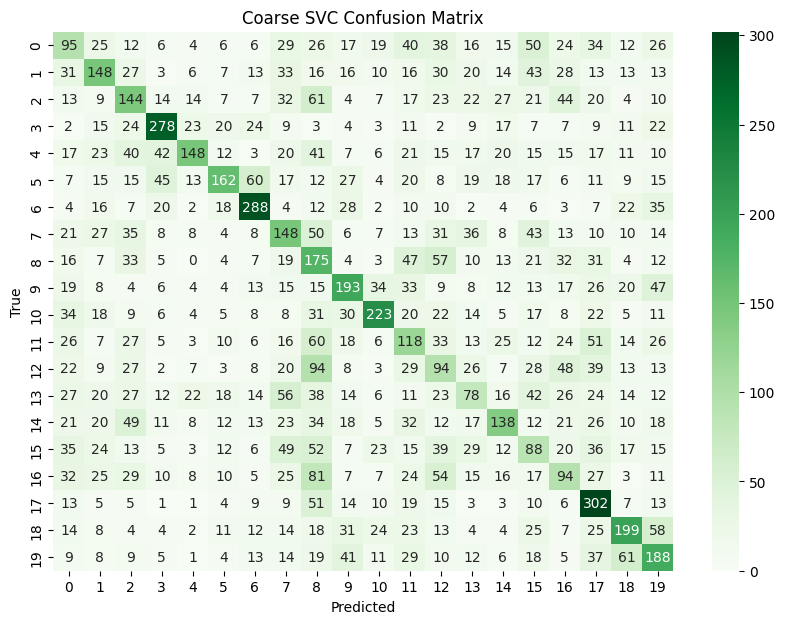

In [ ]:
pyplot.figure(figsize=(10, 7))
class_names = [str(i) for i in range(20)]
sns.heatmap(coarse_hog_cm, annot=True, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.title('Coarse SVC Confusion Matrix')
pyplot.show()

<h4>Fine labels</h4>

In [ ]:
del hog_svm

In [ ]:
hog_svm = SVC(kernel='rbf', C=1.0)
hog_svm.fit(hog_train_pca, fine_labels_train)

SVC()

In [ ]:
hog_pred_fine = hog_svm.predict(hog_ver_pca)

In [ ]:
print("Accuracy:", accuracy_score(fine_labels_ver, hog_pred_fine))
print("Confusion Matrix:")
fine_hog_svm_ver_cm = confusion_matrix(fine_labels_ver, hog_pred_fine)
print("Classification Report:")
print(classification_report(fine_labels_ver, hog_pred_fine))

Accuracy: 0.2419
Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.40      0.49        97
           1       0.16      0.22      0.19        76
           2       0.12      0.05      0.07        97
           3       0.08      0.04      0.06        94
           4       0.11      0.08      0.09       104
           5       0.39      0.28      0.32       115
           6       0.12      0.17      0.14       102
           7       0.15      0.10      0.12       100
           8       0.41      0.38      0.39       103
           9       0.54      0.53      0.54        98
          10       0.25      0.29      0.27       100
          11       0.15      0.08      0.11        95
          12       0.25      0.26      0.25       101
          13       0.33      0.30      0.31        96
          14       0.14      0.19      0.16       104
          15       0.28      0.11      0.15       112
          16       0.33

In [ ]:
hog_test_fine = hog_svm.predict(hog_test_pca)

In [ ]:
print("Test Accuracy:", accuracy_score(tstLabelFine, hog_test_fine))
print("Verification Confusion Matrix:")
fine_hog_cm = confusion_matrix(tstLabelFine, hog_test_fine)
print("Classification Report:")
print(classification_report(tstLabelFine, hog_test_fine))

Test Accuracy: 0.2366
Verification Confusion Matrix:
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.51      0.58       100
           1       0.34      0.32      0.33       100
           2       0.11      0.04      0.06       100
           3       0.04      0.02      0.03       100
           4       0.08      0.10      0.09       100
           5       0.30      0.24      0.27       100
           6       0.08      0.11      0.09       100
           7       0.10      0.07      0.08       100
           8       0.45      0.42      0.43       100
           9       0.51      0.58      0.54       100
          10       0.30      0.29      0.29       100
          11       0.20      0.08      0.11       100
          12       0.25      0.27      0.26       100
          13       0.32      0.28      0.30       100
          14       0.18      0.24      0.21       100
          15       0.24      0.10      0.14       100
     

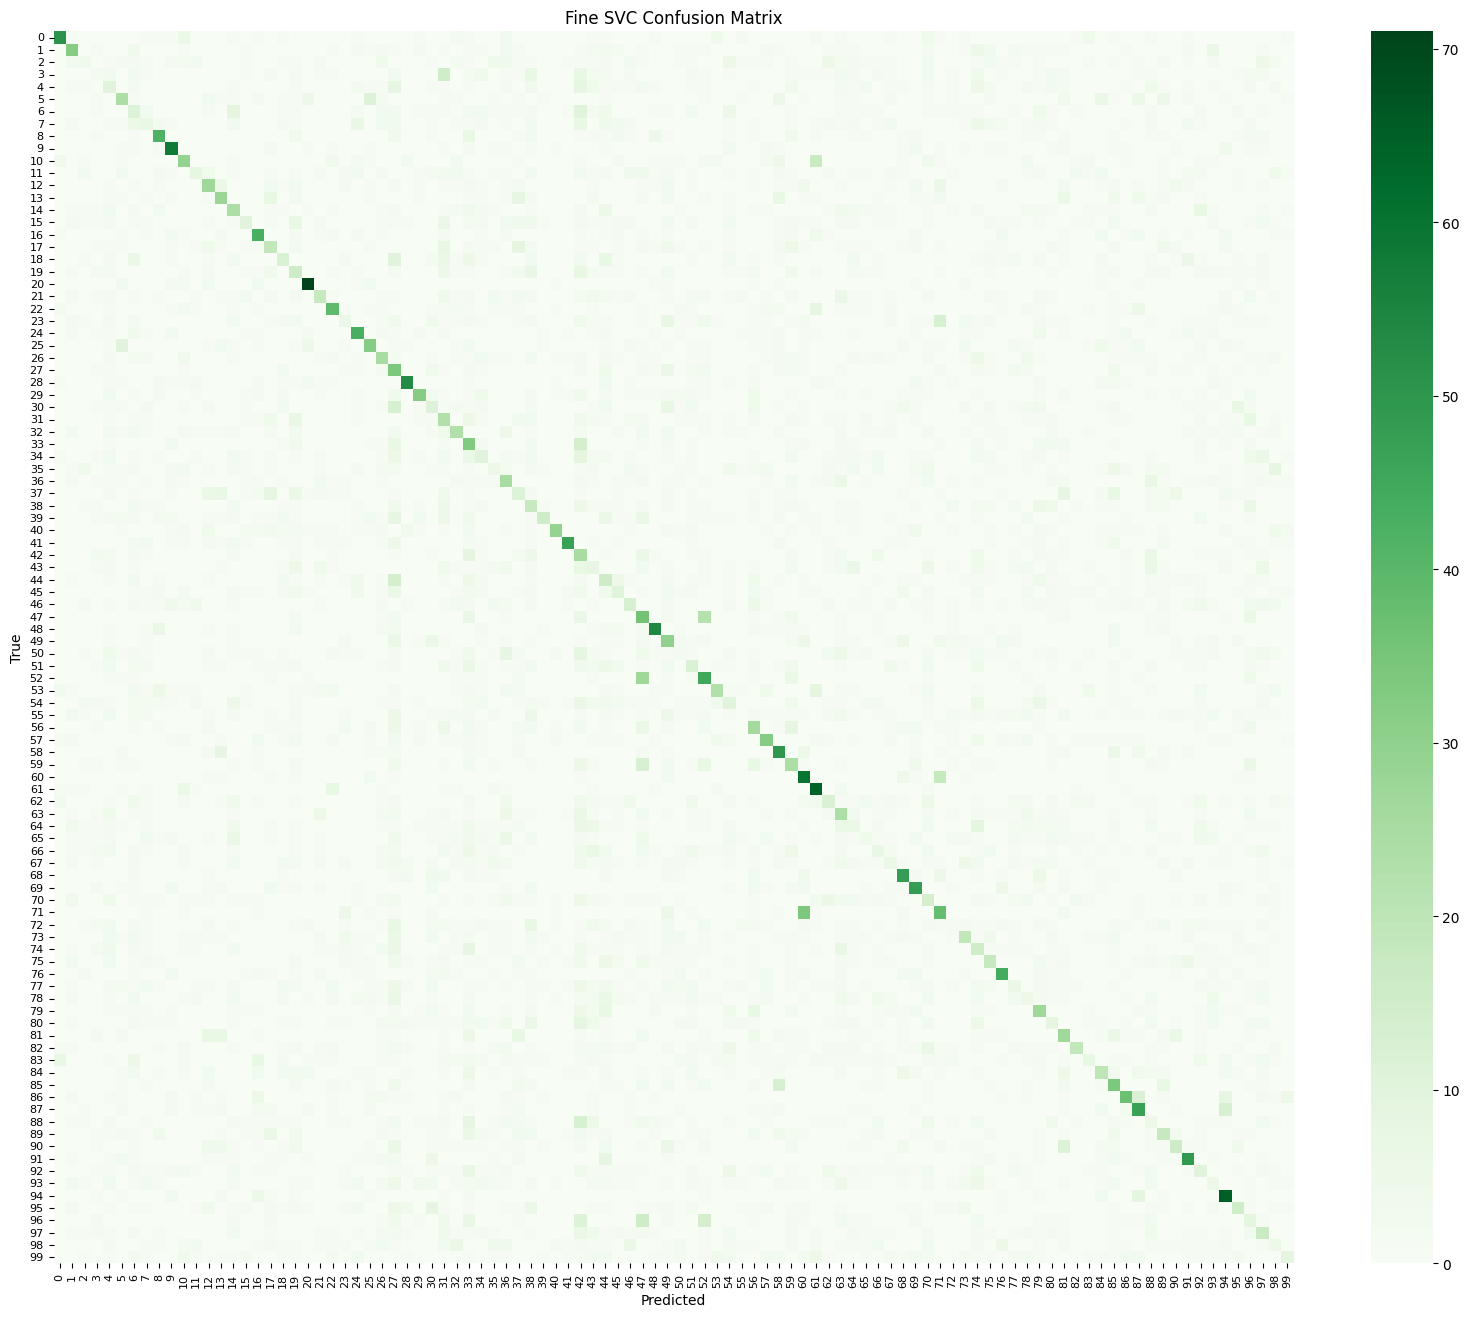

In [ ]:
pyplot.figure(figsize=(20, 16))
class_names = [str(i) for i in range(100)]
sns.heatmap(fine_hog_cm, annot=False, fmt="d", cmap="Greens", xticklabels=class_names, yticklabels=class_names)
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.title('Fine SVC Confusion Matrix')
pyplot.xticks(rotation=90, fontsize=8)
pyplot.yticks(rotation=0, fontsize=8)
pyplot.show()

<h3>Convolutional Neural Network</h3>

<h4>Coarse Convolutional Model</h4>

In [ ]:
conv_model = tf.keras.Sequential(layers=[
    Conv2D(64, kernel_size=(3,3), activation=tf.nn.relu,kernel_regularizer=l2()),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(128, kernel_size=(3,3), activation=tf.nn.relu,kernel_regularizer=l2()),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation=tf.nn.relu),
    Dropout(0.25),
    Dense(20, activation=tf.nn.softmax)
])

conv_model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

<h5>Coarse Labels</h5>

In [ ]:
coarse_conv_history = conv_model.fit(train_data, coarse_labels_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.8957 - sparse_categorical_accuracy: 0.1282 - val_loss: 2.5523 - val_sparse_categorical_accuracy: 0.2105
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 2.5515 - sparse_categorical_accuracy: 0.2155 - val_loss: 2.4209 - val_sparse_categorical_accuracy: 0.2589
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 2.4666 - sparse_categorical_accuracy: 0.2413 - val_loss: 2.3882 - val_sparse_categorical_accuracy: 0.2747
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.4261 - sparse_categorical_accuracy: 0.2592 - val_loss: 2.4003 - val_sparse_categorical_accuracy: 0.2800
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2.4015 - sparse_categorical_accuracy: 0.2654 - val_loss: 2.3645 - val_sparse_categorical_accuracy: 0.2874
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 2.3649 - sparse_categorical_accuracy: 0.2802 - val_loss: 2.3048 - val_sparse_categorical_accurac

In [ ]:
ver_loss, ver_accuracy = conv_model.evaluate(ver_data, coarse_labels_ver, verbose=2)

print(f"Coarse Training Verification Loss: {ver_loss}")
print(f"Coarse Training Verification Accuracy: {ver_accuracy * 100}%")

313/313 - 2s - 7ms/step - loss: 2.0787 - sparse_categorical_accuracy: 0.3922
Coarse Training Verification Loss: 2.0786588191986084
Coarse Training Verification Accuracy: 39.21999931335449%


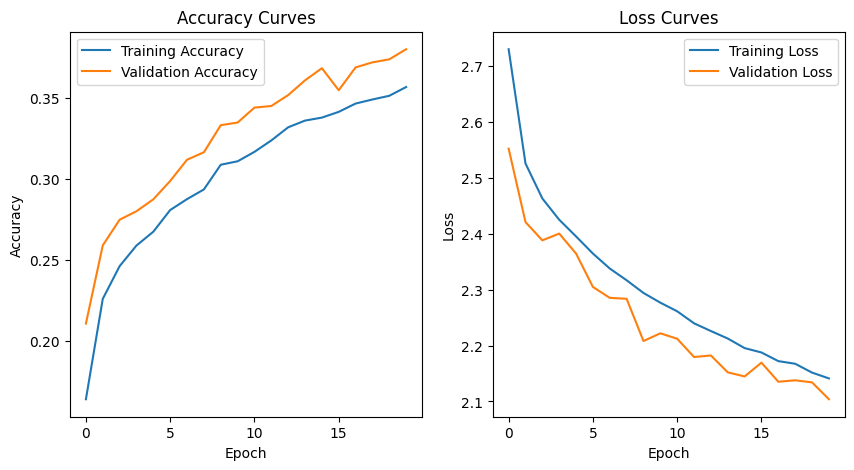

In [ ]:
fig, axes = pyplot.subplots(1, 2, figsize=[10, 5])
axes[0].plot(coarse_conv_history.history['sparse_categorical_accuracy'], label='Training Accuracy')
axes[0].plot(coarse_conv_history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Curves')
axes[0].legend()

axes[1].plot(coarse_conv_history.history['loss'], label='Training Loss')
axes[1].plot(coarse_conv_history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Curves')
axes[1].legend()
pyplot.show()

In [ ]:
coarse_test_loss, coarse_test_accuracy = conv_model.evaluate(transposed_tst_data, tstLabelCoarse, verbose=2)

print(f"Coarse Test Loss: {coarse_test_loss}")
print(f"Coarse Test Accuracy: {coarse_test_accuracy * 100}%")

313/313 - 1s - 2ms/step - loss: 2.0832 - sparse_categorical_accuracy: 0.3877
Coarse Test Loss: 2.083198070526123
Coarse Test Accuracy: 38.76999914646149%


In [ ]:
predictions = conv_model.predict(transposed_tst_data)
predicted_labels = np.argmax(predictions, axis=1)
coarse_confusion_matrix = confusion_matrix(tstLabelCoarse, predicted_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


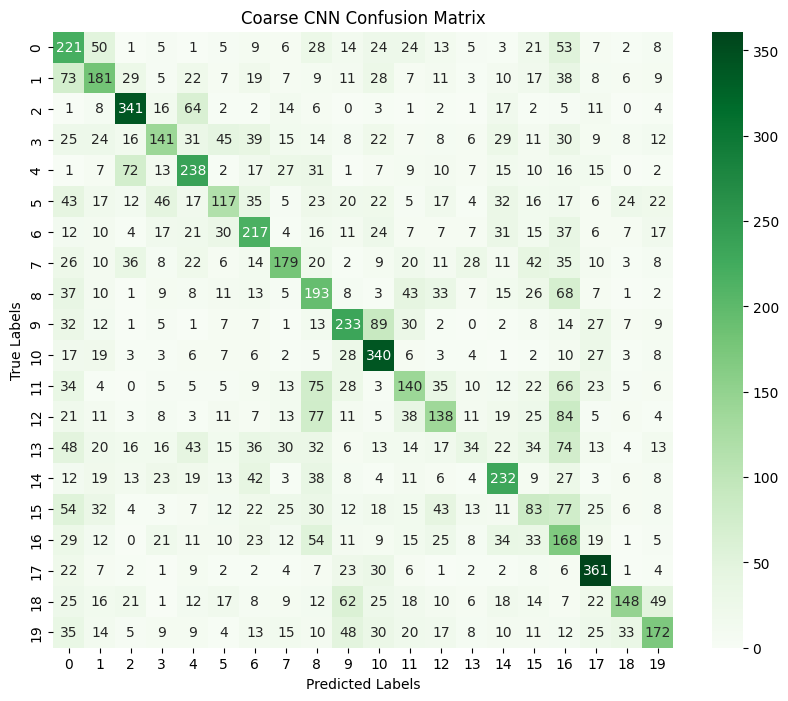

In [ ]:
class_names = [str(i) for i in range(20)]
pyplot.figure(figsize=(10, 8))
sns.heatmap(coarse_confusion_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
pyplot.title('Coarse CNN Confusion Matrix')
pyplot.xlabel('Predicted Labels')
pyplot.ylabel('True Labels')
pyplot.show()

<h5>Fine Labels</h5>

In [ ]:
fine_conv_model = tf.keras.Sequential(layers=[
    Conv2D(64, kernel_size=(3,3), activation=tf.nn.relu,kernel_regularizer=l2()),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(128, kernel_size=(3,3), activation=tf.nn.relu,kernel_regularizer=l2()),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation=tf.nn.relu),
    Dropout(0.25),
    Dense(100, activation=tf.nn.softmax)
])

fine_conv_model.compile(optimizer=Adam(),
              loss=SparseCategoricalCrossentropy(),
              metrics=[SparseCategoricalAccuracy()])

In [ ]:
fine_conv_history = fine_conv_model.fit(train_data, fine_labels_train, epochs=20, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 4.4847 - sparse_categorical_accuracy: 0.0349 - val_loss: 3.9610 - val_sparse_categorical_accuracy: 0.0916
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 3.9494 - sparse_categorical_accuracy: 0.0961 - val_loss: 3.8010 - val_sparse_categorical_accuracy: 0.1335
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.8089 - sparse_categorical_accuracy: 0.1185 - val_loss: 3.7005 - val_sparse_categorical_accuracy: 0.1444
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.7377 - sparse_categorical_accuracy: 0.1302 - val_loss: 3.7074 - val_sparse_categorical_accuracy: 0.1450
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.6608 - sparse_categorical_accuracy: 0.1407 - val_loss: 3.5913 - val_sparse_categorical_accuracy: 0.1625
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 3.6190 - sparse_categorical_accuracy: 0.1477 - val_loss: 3.6061 - val_sparse_categorical_acc

In [ ]:
fine_ver_loss, fine_ver_accuracy = fine_conv_model.evaluate(ver_data, fine_labels_ver, verbose=2)

print(f"Fine Training Verification Loss: {fine_ver_loss}")
print(f"Fine Training Verification Accuracy: {fine_ver_accuracy * 100}%")

313/313 - 2s - 7ms/step - loss: 3.3020 - sparse_categorical_accuracy: 0.2261
Fine Training Verification Loss: 3.302036762237549
Fine Training Verification Accuracy: 22.609999775886536%


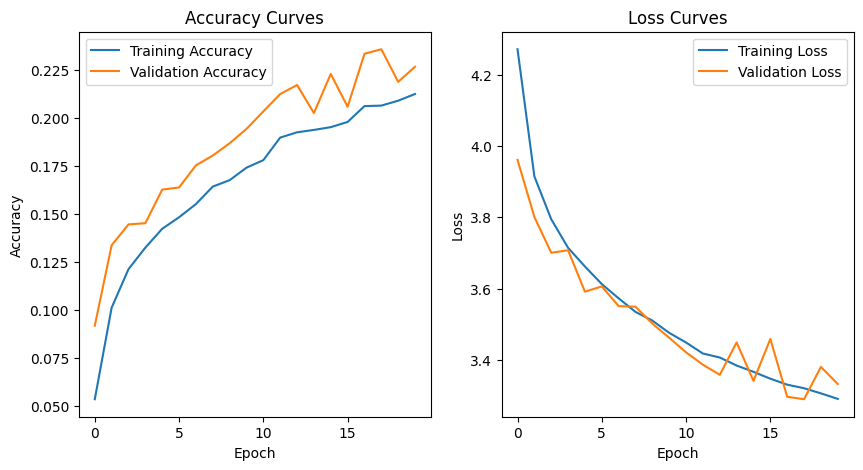

In [ ]:
fig, axes = pyplot.subplots(1, 2, figsize=[10, 5])
axes[0].plot(fine_conv_history.history['sparse_categorical_accuracy'], label='Training Accuracy')
axes[0].plot(fine_conv_history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Curves')
axes[0].legend()

axes[1].plot(fine_conv_history.history['loss'], label='Training Loss')
axes[1].plot(fine_conv_history.history['val_loss'], label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss Curves')
axes[1].legend()
pyplot.show()

In [ ]:
fine_test_loss, fine_test_accuracy = fine_conv_model.evaluate(transposed_tst_data, tstLabelFine, verbose=2)

print(f"Fine Test Loss: {fine_test_loss}")
print(f"Fine Test Accuracy: {fine_test_accuracy * 100}%")

313/313 - 1s - 2ms/step - loss: 3.2998 - sparse_categorical_accuracy: 0.2311
Fine Test Loss: 3.2997851371765137
Fine Test Accuracy: 23.109999299049377%


In [ ]:
fine_predictions = fine_conv_model.predict(transposed_tst_data)
fine_predicted_labels = np.argmax(fine_predictions, axis=1)
fine_confusion_matrix = confusion_matrix(tstLabelFine, fine_predicted_labels)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[71 74 37 ... 18 42 70]


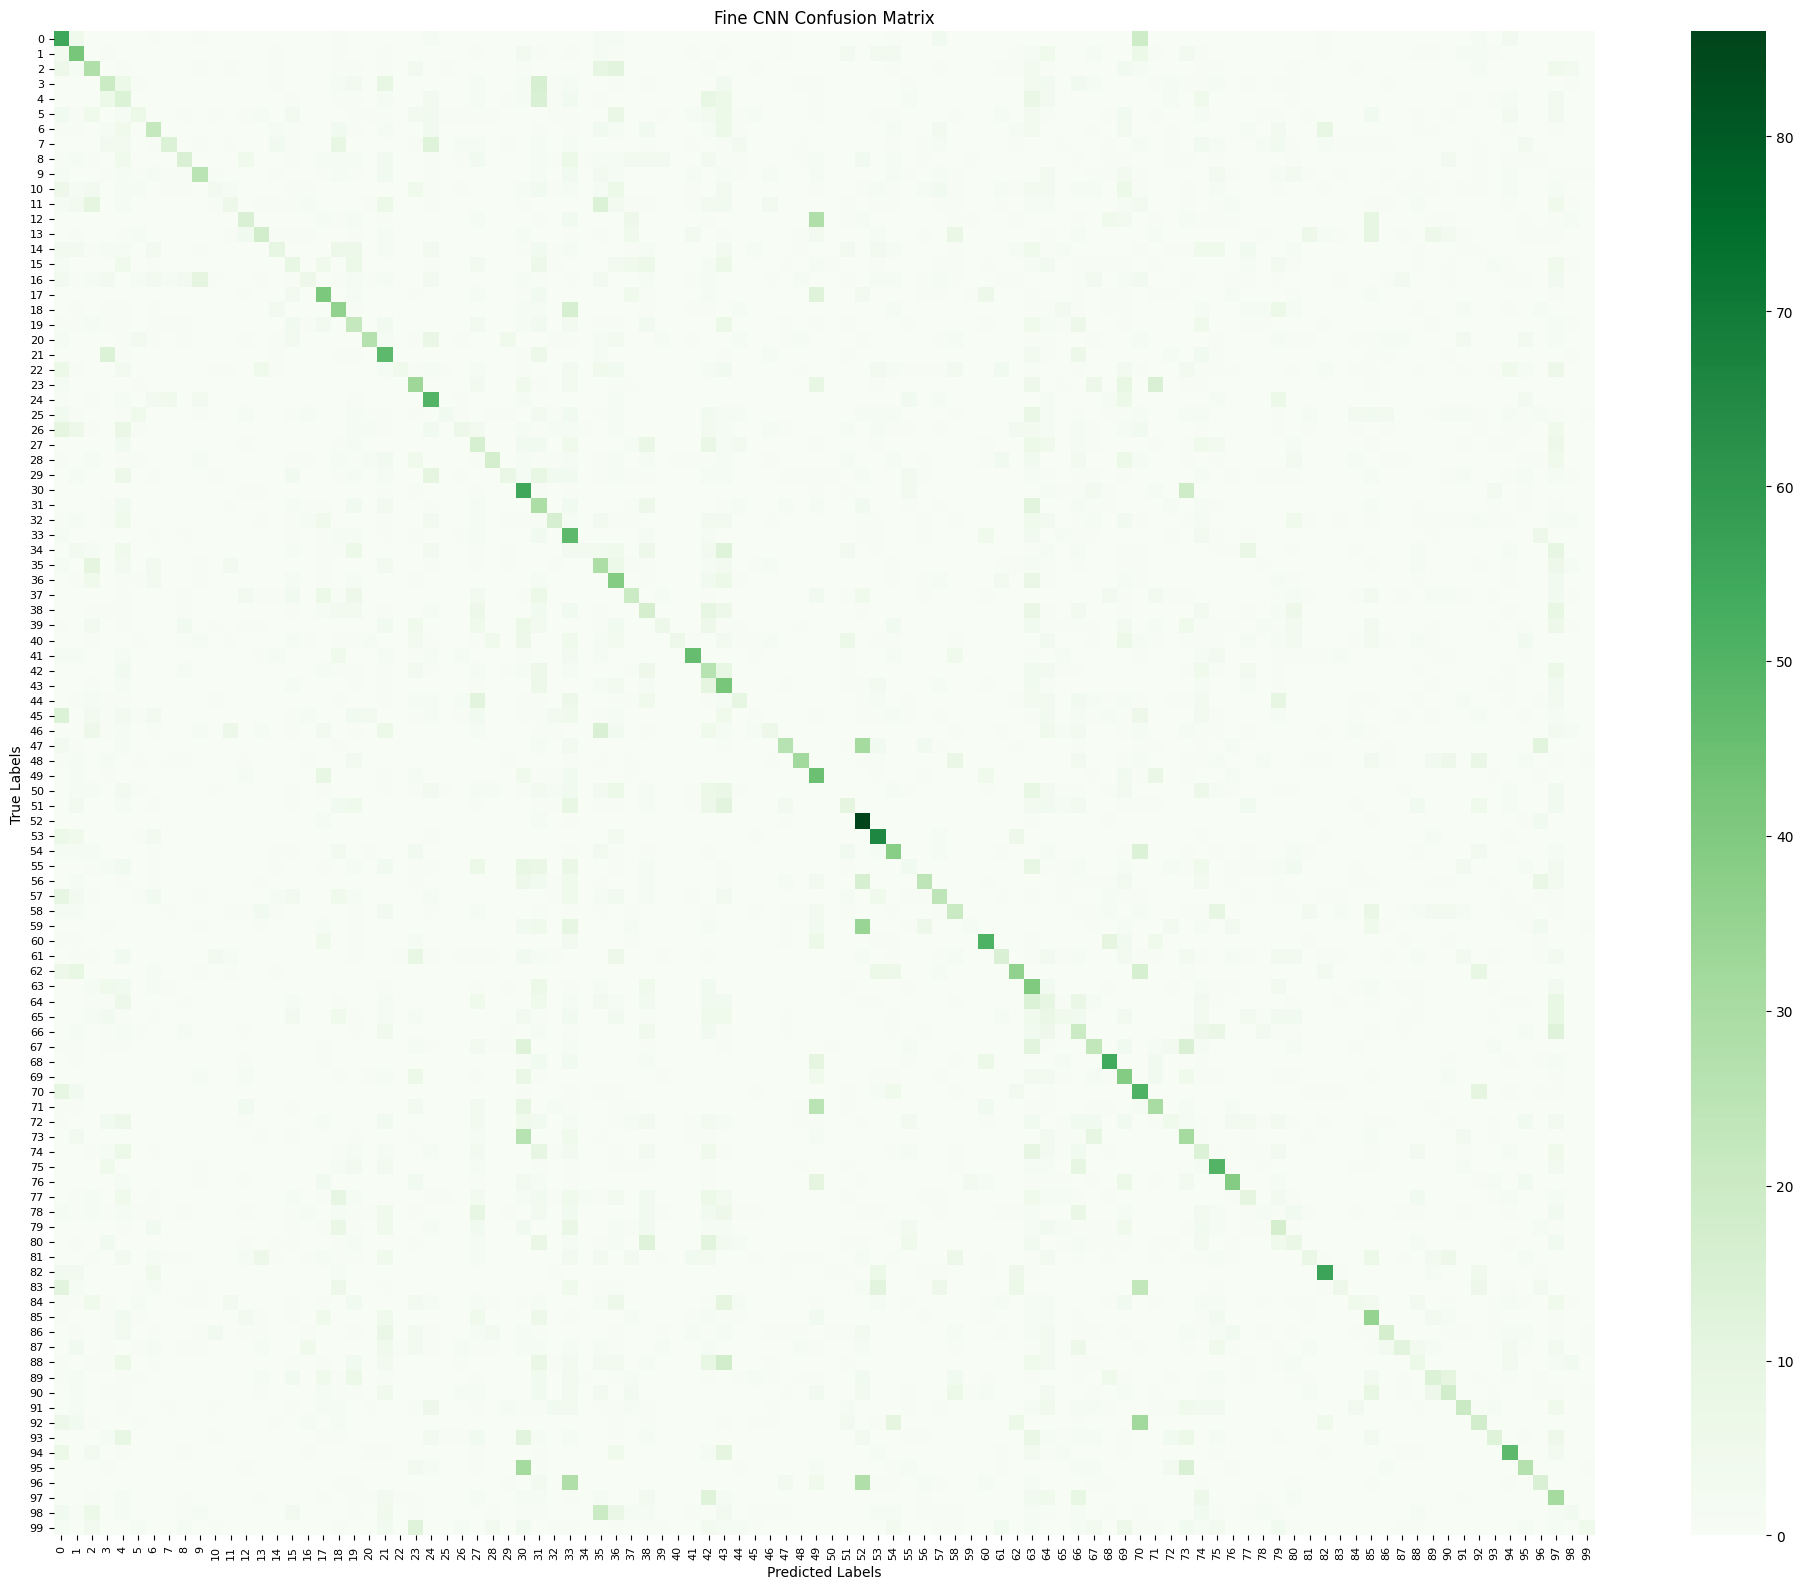

In [ ]:
fine_class_names = [str(i) for i in range(100)]
pyplot.figure(figsize=(20, 16))
sns.heatmap(fine_confusion_matrix, annot=False, fmt='d', cmap='Greens', xticklabels=fine_class_names, yticklabels=fine_class_names)
pyplot.title('Fine CNN Confusion Matrix')
pyplot.xlabel('Predicted Labels')
pyplot.ylabel('True Labels')
pyplot.xticks(rotation=90, fontsize=8)
pyplot.yticks(rotation=0, fontsize=8)
pyplot.tight_layout()
pyplot.show()

<h2>Additional Results</h2>

In [ ]:
report_coarse_svc = classification_report(tstLabelCoarse, hog_test_coarse, output_dict=True)
report_fine_svc = classification_report(tstLabelFine, hog_test_fine, output_dict=True)
report_coarse_cnn = classification_report(tstLabelCoarse, predicted_labels, target_names=[str(i) for i in range(20)], output_dict=True)
report_fine_cnn = classification_report(tstLabelFine, fine_predicted_labels, target_names=[str(i) for i in range(100)], output_dict=True)

In [ ]:
accuracy_coarse_svc = report_coarse_svc['accuracy']
accuracy_fine_svc = report_fine_svc['accuracy']
accuracy_coarse_cnn = report_coarse_cnn['accuracy']
accuracy_fine_cnn = report_fine_cnn['accuracy']

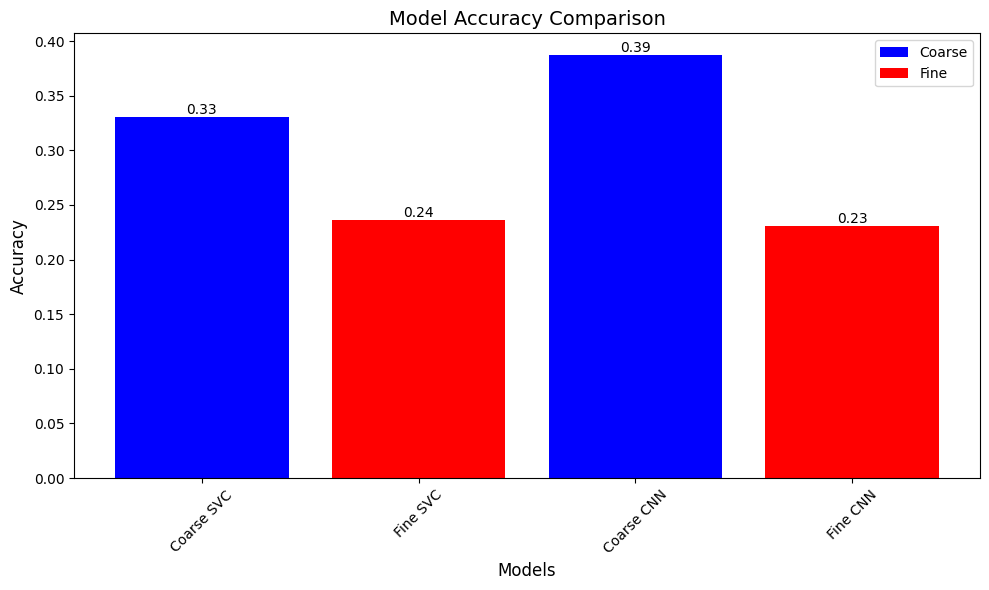

In [ ]:
labels = ['Coarse SVC', 'Fine SVC', 'Coarse CNN', 'Fine CNN']
svc_accuracies = [accuracy_coarse_svc, accuracy_fine_svc]
cnn_accuracies = [accuracy_coarse_cnn, accuracy_fine_cnn]

pyplot.figure(figsize=(10, 6))
x = np.arange(len(svc_accuracies) + len(cnn_accuracies))
coarse_colour = 'blue'
fine_colour = 'red'
pyplot.bar(0, svc_accuracies[0], color=coarse_colour, width=0.8, label='Coarse')
pyplot.bar(1, svc_accuracies[1], color=fine_colour, width=0.8, label='Fine')
pyplot.bar(2, cnn_accuracies[0], color=coarse_colour, width=0.8)
pyplot.bar(3, cnn_accuracies[1], color=fine_colour, width=0.8)
pyplot.xlabel('Models', fontsize=12)
pyplot.ylabel('Accuracy', fontsize=12)
pyplot.title('Model Accuracy Comparison', fontsize=14)
pyplot.xticks(x, labels, rotation=45)
for i, v in enumerate(svc_accuracies + cnn_accuracies):
    pyplot.text(i, v, f'{v:.2f}', ha='center', va='bottom')
pyplot.tight_layout()
pyplot.legend()
pyplot.show()


In [ ]:
print(classification_report(tstLabelCoarse, hog_test_coarse))

              precision    recall  f1-score   support

           0       0.21      0.19      0.20       500
           1       0.34      0.30      0.32       500
           2       0.27      0.29      0.28       500
           3       0.57      0.56      0.56       500
           4       0.53      0.30      0.38       500
           5       0.49      0.32      0.39       500
           6       0.55      0.58      0.56       500
           7       0.26      0.30      0.28       500
           8       0.20      0.35      0.25       500
           9       0.39      0.39      0.39       500
          10       0.54      0.45      0.49       500
          11       0.22      0.24      0.23       500
          12       0.17      0.19      0.18       500
          13       0.21      0.16      0.18       500
          14       0.36      0.28      0.31       500
          15       0.17      0.18      0.18       500
          16       0.21      0.19      0.20       500
          17       0.39    

In [ ]:
print(classification_report(tstLabelFine, hog_test_fine))

              precision    recall  f1-score   support

           0       0.67      0.51      0.58       100
           1       0.34      0.32      0.33       100
           2       0.11      0.04      0.06       100
           3       0.04      0.02      0.03       100
           4       0.08      0.10      0.09       100
           5       0.30      0.24      0.27       100
           6       0.08      0.11      0.09       100
           7       0.10      0.07      0.08       100
           8       0.45      0.42      0.43       100
           9       0.51      0.58      0.54       100
          10       0.30      0.29      0.29       100
          11       0.20      0.08      0.11       100
          12       0.25      0.27      0.26       100
          13       0.32      0.28      0.30       100
          14       0.18      0.24      0.21       100
          15       0.24      0.10      0.14       100
          16       0.40      0.43      0.42       100
          17       0.20    

In [ ]:
print(classification_report(tstLabelCoarse, predicted_labels, target_names=[str(i) for i in range(20)]))

              precision    recall  f1-score   support

           0       0.29      0.44      0.35       500
           1       0.37      0.36      0.37       500
           2       0.59      0.68      0.63       500
           3       0.40      0.28      0.33       500
           4       0.43      0.48      0.45       500
           5       0.36      0.23      0.28       500
           6       0.40      0.43      0.42       500
           7       0.46      0.36      0.40       500
           8       0.28      0.39      0.32       500
           9       0.43      0.47      0.45       500
          10       0.48      0.68      0.56       500
          11       0.32      0.28      0.30       500
          12       0.34      0.28      0.30       500
          13       0.20      0.07      0.10       500
          14       0.44      0.46      0.45       500
          15       0.20      0.17      0.18       500
          16       0.20      0.34      0.25       500
          17       0.57    

In [ ]:
print(classification_report(tstLabelFine, fine_predicted_labels, target_names=[str(i) for i in range(100)]))

              precision    recall  f1-score   support

           0       0.24      0.55      0.34       100
           1       0.27      0.42      0.33       100
           2       0.21      0.28      0.24       100
           3       0.19      0.20      0.20       100
           4       0.07      0.14      0.09       100
           5       0.16      0.07      0.10       100
           6       0.25      0.22      0.24       100
           7       0.48      0.14      0.22       100
           8       0.33      0.15      0.21       100
           9       0.38      0.25      0.30       100
          10       0.14      0.03      0.05       100
          11       0.20      0.06      0.09       100
          12       0.26      0.15      0.19       100
          13       0.33      0.18      0.23       100
          14       0.25      0.10      0.14       100
          15       0.11      0.09      0.10       100
          16       0.18      0.06      0.09       100
          17       0.32    